# Airbnb Data cleaning & Exploratory Data Analysis

#### Importing necessory Libraries 

In [1]:
import pandas as pd
import numpy as np

#### Import Data from Google sheets and merge into single dataset

In [2]:
sheet_id = '1ecopK6oyyb4d_7-QLrCr8YlgFrCetHU7-VQfnYej7JY'
export_url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx'

In [3]:
xls = pd.ExcelFile(export_url)

In [4]:
dfs = []
for sheet in xls.sheet_names:
    df_temp = pd.read_excel(xls, sheet_name=sheet)
    df_temp['source'] = sheet
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

#### Adding City and Country Columns

In [5]:
df['city'] = df['source'].apply(lambda x: x.split('_')[0].capitalize())
df['day_type'] = df['source'].apply(lambda x: x.split('_')[1].capitalize())

city_country_map = {
    'Amsterdam': 'Netherlands',
    'Athens': 'Greece',
    'Berlin': 'Germany',
    'Barcelona': 'Spain',
    'Budapest': 'Hungary',
    'Lisbon': 'Portugal',
    'London': 'United Kingdom',
    'Paris': 'France',
    'Rome': 'Italy',
    'Vienna': 'Austria',
}
df['country'] = df['city'].map(city_country_map)

#### Renaming 'realSum' column & removing 'Unnamed: 0' column

In [9]:
df.rename(columns={'realSum': 'price'}, inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

In [11]:
other_cols = [col for col in df.columns if col not in ['source', 'city', 'day_type']]
df = df[['source', 'city', 'day_type'] + other_cols]

In [12]:
df.head()

,source,city,day_type,price,room_type,is_shared_room,is_private_room,capacity,is_superhost,multi_listing,...,num_bedrooms,distance_to_center,distance_to_metro,attraction_index,attraction_index_norm,restaurant_index,restaurant_index_norm,longitude,latitude,country
0,amsterdam_weekdays,Amsterdam,Weekdays,194.033698,Private room,False,True,2,False,1,...,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Netherlands
1,amsterdam_weekdays,Amsterdam,Weekdays,344.245776,Private room,False,True,4,False,0,...,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Netherlands
2,amsterdam_weekdays,Amsterdam,Weekdays,264.101422,Private room,False,True,2,False,0,...,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Netherlands
3,amsterdam_weekdays,Amsterdam,Weekdays,433.529398,Private room,False,True,4,False,0,...,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Netherlands
4,amsterdam_weekdays,Amsterdam,Weekdays,485.552926,Private room,False,True,2,True,0,...,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Netherlands


#### Removing unnecessary decimal values from the values

In [17]:
cols_to_round = [
    'price', 'distance_to_center', 'distance_to_metro',
    'attraction_index', 'attraction_index_norm',
    'restaurant_index', 'restaurant_index_norm'
]
df[cols_to_round] = df[cols_to_round].round(2)

In [18]:
df.head()

,source,city,day_type,price,room_type,is_shared_room,is_private_room,capacity,is_superhost,multi_listing,...,num_bedrooms,distance_to_center,distance_to_metro,attraction_index,attraction_index_norm,restaurant_index,restaurant_index_norm,longitude,latitude,country
0,amsterdam_weekdays,Amsterdam,Weekdays,194.03,Private room,False,True,2,False,1,...,1,5.02,2.54,78.69,4.17,98.25,6.85,4.90569,52.41772,Netherlands
1,amsterdam_weekdays,Amsterdam,Weekdays,344.25,Private room,False,True,4,False,0,...,1,0.49,0.24,631.18,33.42,837.28,58.34,4.90005,52.37432,Netherlands
2,amsterdam_weekdays,Amsterdam,Weekdays,264.10,Private room,False,True,2,False,0,...,1,5.75,3.65,75.28,3.99,95.39,6.65,4.97512,52.36103,Netherlands
3,amsterdam_weekdays,Amsterdam,Weekdays,433.53,Private room,False,True,4,False,0,...,2,0.38,0.44,493.27,26.12,875.03,60.97,4.89417,52.37663,Netherlands
4,amsterdam_weekdays,Amsterdam,Weekdays,485.55,Private room,False,True,2,True,0,...,1,0.54,0.32,552.83,29.27,815.31,56.81,4.90051,52.37508,Netherlands


In [19]:
df_backup = df.copy(deep=True)

In [22]:
print(df.shape)
print(df_backup.shape)

(51707, 23)
(51707, 23)


#### Define possible column names for different feature groups

In [24]:
shared_candidates = ['is_shared_room']
private_candidates = ['is_private_room']
multi_candidates = ['multi_listing']
biz_candidates = ['is_business']
host_total_candidates = ['is_superhost']

def find_column(candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

col_shared = find_column(shared_candidates)
col_private = find_column(private_candidates)
col_multi  = find_column(multi_candidates)
col_biz    = find_column(biz_candidates)
col_host_total = find_column(host_total_candidates)

#### Function to classify listings based on room type flags

In [25]:
def make_room_category(row):
    if row['is_shared_room']:
        return 'Shared room'
    elif row['is_private_room']:
        return 'Private room'
    else:
        return 'Entire home/apt'

df['room_category'] = df.apply(make_room_category, axis=1)

In [26]:
def make_host_category(row):
    if row['is_business']:
        return '>4 listings'
    elif row['multi_listing']:
        return '2–4 listings'
    else:
        return '1 listing'

df['host_listings_category'] = df.apply(make_host_category, axis=1)

In [27]:
df.head()

,source,city,day_type,price,room_type,is_shared_room,is_private_room,capacity,is_superhost,multi_listing,...,distance_to_metro,attraction_index,attraction_index_norm,restaurant_index,restaurant_index_norm,longitude,latitude,country,room_category,host_listings_category
0,amsterdam_weekdays,Amsterdam,Weekdays,194.03,Private room,False,True,2,False,1,...,2.54,78.69,4.17,98.25,6.85,4.90569,52.41772,Netherlands,Private room,2–4 listings
1,amsterdam_weekdays,Amsterdam,Weekdays,344.25,Private room,False,True,4,False,0,...,0.24,631.18,33.42,837.28,58.34,4.90005,52.37432,Netherlands,Private room,1 listing
2,amsterdam_weekdays,Amsterdam,Weekdays,264.10,Private room,False,True,2,False,0,...,3.65,75.28,3.99,95.39,6.65,4.97512,52.36103,Netherlands,Private room,>4 listings
3,amsterdam_weekdays,Amsterdam,Weekdays,433.53,Private room,False,True,4,False,0,...,0.44,493.27,26.12,875.03,60.97,4.89417,52.37663,Netherlands,Private room,>4 listings
4,amsterdam_weekdays,Amsterdam,Weekdays,485.55,Private room,False,True,2,True,0,...,0.32,552.83,29.27,815.31,56.81,4.90051,52.37508,Netherlands,Private room,1 listing


In [29]:
df = df.drop(columns=['room_type'], errors='ignore')

In [31]:
pd.set_option('display.max_columns', None)
df.head()

,source,city,day_type,price,is_shared_room,is_private_room,capacity,is_superhost,multi_listing,is_business,cleanliness_score,guest_rating,num_bedrooms,distance_to_center,distance_to_metro,attraction_index,attraction_index_norm,restaurant_index,restaurant_index_norm,longitude,latitude,country,room_category,host_listings_category
0,amsterdam_weekdays,Amsterdam,Weekdays,194.03,False,True,2,False,1,0,10,93,1,5.02,2.54,78.69,4.17,98.25,6.85,4.90569,52.41772,Netherlands,Private room,2–4 listings
1,amsterdam_weekdays,Amsterdam,Weekdays,344.25,False,True,4,False,0,0,8,85,1,0.49,0.24,631.18,33.42,837.28,58.34,4.90005,52.37432,Netherlands,Private room,1 listing
2,amsterdam_weekdays,Amsterdam,Weekdays,264.10,False,True,2,False,0,1,9,87,1,5.75,3.65,75.28,3.99,95.39,6.65,4.97512,52.36103,Netherlands,Private room,>4 listings
3,amsterdam_weekdays,Amsterdam,Weekdays,433.53,False,True,4,False,0,1,9,90,2,0.38,0.44,493.27,26.12,875.03,60.97,4.89417,52.37663,Netherlands,Private room,>4 listings
4,amsterdam_weekdays,Amsterdam,Weekdays,485.55,False,True,2,True,0,0,10,98,1,0.54,0.32,552.83,29.27,815.31,56.81,4.90051,52.37508,Netherlands,Private room,1 listing


In [32]:
new_column_order = [
    'source', 'city', 'country', 'day_type',
    'room_category', 'capacity', 'num_bedrooms',
    'price', 'guest_rating', 'cleanliness_score',
    'is_superhost', 'host_listings_category',
    'distance_to_center', 'distance_to_metro', 'longitude', 'latitude',
    'attraction_index', 'attraction_index_norm',
    'restaurant_index', 'restaurant_index_norm',
    'is_shared_room', 'is_private_room', 'multi_listing', 'is_business'
]

new_column_order = [col for col in new_column_order if col in df.columns]

df = df[new_column_order]

In [33]:
df.head()

,source,city,country,day_type,room_category,capacity,num_bedrooms,price,guest_rating,cleanliness_score,is_superhost,host_listings_category,distance_to_center,distance_to_metro,longitude,latitude,attraction_index,attraction_index_norm,restaurant_index,restaurant_index_norm,is_shared_room,is_private_room,multi_listing,is_business
0,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,2,1,194.03,93,10,False,2–4 listings,5.02,2.54,4.90569,52.41772,78.69,4.17,98.25,6.85,False,True,1,0
1,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,4,1,344.25,85,8,False,1 listing,0.49,0.24,4.90005,52.37432,631.18,33.42,837.28,58.34,False,True,0,0
2,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,2,1,264.10,87,9,False,>4 listings,5.75,3.65,4.97512,52.36103,75.28,3.99,95.39,6.65,False,True,0,1
3,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,4,2,433.53,90,9,False,>4 listings,0.38,0.44,4.89417,52.37663,493.27,26.12,875.03,60.97,False,True,0,1
4,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,2,1,485.55,98,10,True,1 listing,0.54,0.32,4.90051,52.37508,552.83,29.27,815.31,56.81,False,True,0,0


In [34]:
cols_to_drop = [
    'is_shared_room',       
    'is_private_room',      
    'multi_listing',        
    'is_business',          
    'attraction_index',     
    'restaurant_index'      
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

#### Reordering columns for better understanding

In [35]:
df = df[
    [
        'source', 'city', 'country', 'day_type',
        'room_category', 'capacity', 'num_bedrooms',
        'price', 'guest_rating', 'cleanliness_score',
        'is_superhost', 'host_listings_category',
        'distance_to_center', 'distance_to_metro', 'longitude', 'latitude',
        'attraction_index_norm', 'restaurant_index_norm'
    ]
]

In [36]:
print(df.shape)
df.head()

(51707, 18)


,source,city,country,day_type,room_category,capacity,num_bedrooms,price,guest_rating,cleanliness_score,is_superhost,host_listings_category,distance_to_center,distance_to_metro,longitude,latitude,attraction_index_norm,restaurant_index_norm
0,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,2,1,194.03,93,10,False,2–4 listings,5.02,2.54,4.90569,52.41772,4.17,6.85
1,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,4,1,344.25,85,8,False,1 listing,0.49,0.24,4.90005,52.37432,33.42,58.34
2,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,2,1,264.10,87,9,False,>4 listings,5.75,3.65,4.97512,52.36103,3.99,6.65
3,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,4,2,433.53,90,9,False,>4 listings,0.38,0.44,4.89417,52.37663,26.12,60.97
4,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,2,1,485.55,98,10,True,1 listing,0.54,0.32,4.90051,52.37508,29.27,56.81


#### Exploratory Data Analysis (EDA)

In [48]:
df.isna().sum() # Finding any null values

source                    0
city                      0
country                   0
day_type                  0
room_category             0
capacity                  0
num_bedrooms              0
price                     0
guest_rating              0
cleanliness_score         0
is_superhost              0
host_listings_category    0
distance_to_center        0
distance_to_metro         0
longitude                 0
latitude                  0
attraction_index_norm     0
restaurant_index_norm     0
dtype: int64

In [49]:
df.duplicated().sum() # finding any duplicate row

0

In [50]:
df = df.drop_duplicates()

In [51]:
df.dtypes 

source                      object
city                      category
country                   category
day_type                  category
room_category             category
capacity                     int64
num_bedrooms                 int64
price                      float64
guest_rating               float64
cleanliness_score          float64
is_superhost                  bool
host_listings_category    category
distance_to_center         float64
distance_to_metro          float64
longitude                  float64
latitude                   float64
attraction_index_norm      float64
restaurant_index_norm      float64
dtype: object

In [41]:
df['guest_rating'] = df['guest_rating'].astype(float)
df['cleanliness_score'] = df['cleanliness_score'].astype(float)

In [42]:
cat_cols = ['city', 'country', 'day_type', 'room_category', 'host_listings_category']
for col in cat_cols:
    df[col] = df[col].astype('category')

In [43]:
df[df['price'] <= 0]
df[df['distance_to_center'] > 50]
df[(df['guest_rating'] > 100) | (df['guest_rating'] < 0)]

,source,city,country,day_type,room_category,capacity,num_bedrooms,price,guest_rating,cleanliness_score,is_superhost,host_listings_category,distance_to_center,distance_to_metro,longitude,latitude,attraction_index_norm,restaurant_index_norm


In [44]:
df.to_csv("airbnb_final_clean_ready.csv", index=False)
print("Final cleaned dataset saved: airbnb_final_clean_ready.csv")

Final cleaned dataset saved: airbnb_final_clean_ready.csv


In [55]:
print("First 5 rows:")
df.head()

First 5 rows:


,source,city,country,day_type,room_category,capacity,num_bedrooms,price,guest_rating,cleanliness_score,is_superhost,host_listings_category,distance_to_center,distance_to_metro,longitude,latitude,attraction_index_norm,restaurant_index_norm
0,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,2,1,194.03,93.0,10.0,False,2–4 listings,5.02,2.54,4.90569,52.41772,4.17,6.85
1,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,4,1,344.25,85.0,8.0,False,1 listing,0.49,0.24,4.90005,52.37432,33.42,58.34
2,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,2,1,264.10,87.0,9.0,False,>4 listings,5.75,3.65,4.97512,52.36103,3.99,6.65
3,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,4,2,433.53,90.0,9.0,False,>4 listings,0.38,0.44,4.89417,52.37663,26.12,60.97
4,amsterdam_weekdays,Amsterdam,Netherlands,Weekdays,Private room,2,1,485.55,98.0,10.0,True,1 listing,0.54,0.32,4.90051,52.37508,29.27,56.81


In [56]:
print("Last 5 rows:")
df.tail()

Last 5 rows:


,source,city,country,day_type,room_category,capacity,num_bedrooms,price,guest_rating,cleanliness_score,is_superhost,host_listings_category,distance_to_center,distance_to_metro,longitude,latitude,attraction_index_norm,restaurant_index_norm
51702,vienna_weekends,Vienna,Austria,Weekends,Entire home/apt,6,3,715.94,100.0,10.0,False,>4 listings,0.53,0.14,16.37940,48.21136,15.71,10.60
51703,vienna_weekends,Vienna,Austria,Weekends,Entire home/apt,2,1,304.79,86.0,8.0,False,1 listing,0.81,0.10,16.38070,48.20296,14.68,8.27
51704,vienna_weekends,Vienna,Austria,Weekends,Entire home/apt,2,1,637.17,93.0,10.0,False,1 listing,0.99,0.20,16.38568,48.20460,12.11,6.82
51705,vienna_weekends,Vienna,Austria,Weekends,Private room,2,1,301.05,87.0,10.0,False,1 listing,3.04,0.29,16.34100,48.19200,7.82,3.83
51706,vienna_weekends,Vienna,Austria,Weekends,Private room,4,1,133.23,93.0,10.0,True,2–4 listings,1.26,0.48,16.39066,48.20811,10.77,5.44


In [57]:
print("Random sample of 7 rows: ")
df.sample(7)

Random sample of 7 rows: 


,source,city,country,day_type,room_category,capacity,num_bedrooms,price,guest_rating,cleanliness_score,is_superhost,host_listings_category,distance_to_center,distance_to_metro,longitude,latitude,attraction_index_norm,restaurant_index_norm
5125,athens_weekends,Athens,Greece,Weekends,Entire home/apt,3,0,138.03,95.0,9.0,True,2–4 listings,1.10,0.33,23.72349,37.97856,8.71,10.64
43132,rome_weekdays,Rome,Italy,Weekdays,Entire home/apt,4,2,191.48,90.0,9.0,False,>4 listings,0.53,0.41,12.49900,41.90500,11.14,29.25
39180,rome_weekdays,Rome,Italy,Weekdays,Private room,4,1,173.01,97.0,10.0,True,>4 listings,3.60,0.43,12.47743,41.87432,7.25,20.41
46462,rome_weekends,Rome,Italy,Weekends,Entire home/apt,4,1,484.18,96.0,10.0,True,1 listing,2.46,1.42,12.47341,41.89588,19.55,52.44
13740,budapest_weekdays,Budapest,Hungary,Weekdays,Private room,2,1,67.21,93.0,10.0,False,>4 listings,1.96,0.21,19.08028,47.49868,7.63,21.94
29788,london_weekends,London,United Kingdom,Weekends,Private room,2,1,134.29,98.0,10.0,True,1 listing,7.36,2.20,-0.11072,51.44302,10.49,5.61
36691,paris_weekends,Paris,France,Weekends,Private room,2,1,254.68,93.0,10.0,False,1 listing,4.71,0.08,2.29278,48.87180,24.08,35.46


In [61]:
print("Data types and non-null counts: ")
print(df.info())

Data types and non-null counts: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 51617 entries, 0 to 51706
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   source                  51617 non-null  object  
 1   city                    51617 non-null  category
 2   country                 51617 non-null  category
 3   day_type                51617 non-null  category
 4   room_category           51617 non-null  category
 5   capacity                51617 non-null  int64   
 6   num_bedrooms            51617 non-null  int64   
 7   price                   51617 non-null  float64 
 8   guest_rating            51617 non-null  float64 
 9   cleanliness_score       51617 non-null  float64 
 10  is_superhost            51617 non-null  bool    
 11  host_listings_category  51617 non-null  category
 12  distance_to_center      51617 non-null  float64 
 13  distance_to_metro       51617 non-null  flo

In [64]:
print("Summary statistics for numerical columns: ")
df.describe().T

Summary statistics for numerical columns: 


,count,mean,std,min,25%,50%,75%,max
capacity,51617.0,3.162446,1.298538,2.00000,2.00000,3.00000,4.00000,6.00000
num_bedrooms,51617.0,1.159347,0.627380,0.00000,1.00000,1.00000,1.00000,10.00000
price,51617.0,279.967888,328.185428,34.78000,148.87000,211.43000,319.69000,18545.45000
guest_rating,51617.0,92.621617,8.949491,20.00000,90.00000,95.00000,99.00000,100.00000
cleanliness_score,51617.0,9.389775,0.955325,2.00000,9.00000,10.00000,10.00000,10.00000
distance_to_center,51617.0,3.193031,2.394816,0.02000,1.45000,2.62000,4.27000,25.28000
distance_to_metro,51617.0,0.681960,0.858544,0.00000,0.25000,0.41000,0.74000,14.27000
longitude,51617.0,7.421416,9.796903,-9.22634,-0.07262,4.87254,13.51206,23.78602
latitude,51617.0,45.674166,5.249306,37.95300,41.39975,47.50677,51.47222,52.64141
attraction_index_norm,51617.0,13.426977,9.810347,0.93000,6.39000,11.47000,17.42000,100.00000


In [68]:
print("Summary statistics for categorical columns: ")
df.describe(include = ['category', 'bool', 'object']).T

Summary statistics for categorical columns: 


,count,unique,top,freq
source,51617,20,london_weekends,5377
city,51617,10,London,9988
country,51617,10,United Kingdom,9988
day_type,51617,2,Weekends,26162
room_category,51617,3,Entire home/apt,32599
is_superhost,51617,2,False,38429
host_listings_category,51617,3,1 listing,18534


#### 1. How many listings are in each city (total and per day type)?

In [84]:
print("Total listings per city:\n")
print(df['city'].value_counts().to_string()) # Total listings per city

print("\nListings per city and day type:\n")
print(df.groupby(['city', 'day_type']).size().to_string()) # Listings per city and day type

Total listings per city:

London       9988
Rome         9010
Paris        6672
Lisbon       5750
Athens       5262
Budapest     4014
Vienna       3526
Barcelona    2833
Berlin       2483
Amsterdam    2079

Listings per city and day type:

city       day_type
Amsterdam  Weekdays    1102
           Weekends     977
Athens     Weekdays    2645
           Weekends    2617
Barcelona  Weekdays    1555
           Weekends    1278
Berlin     Weekdays    1283
           Weekends    1200
Budapest   Weekdays    2070
           Weekends    1944
Lisbon     Weekdays    2851
           Weekends    2899
London     Weekdays    4611
           Weekends    5377
Paris      Weekdays    3122
           Weekends    3550
Rome       Weekdays    4482
           Weekends    4528
Vienna     Weekdays    1734
           Weekends    1792


#### 2. Which city has the biggest proportion of superhosts?

In [92]:
superhost = df.groupby('city')['is_superhost'].mean().sort_values(ascending= False)*100
print(superhost.round(2).to_string())

city
Athens       42.82
Budapest     37.77
Rome         32.69
Amsterdam    28.38
Vienna       28.25
Berlin       25.69
Lisbon       21.30
Barcelona    18.14
London       15.74
Paris        14.07


#### 3. Which cities have listings with more than four rooms?

In [95]:
print(df[df['num_bedrooms'] > 4]['city'].value_counts().to_string())

Lisbon       10
London        5
Amsterdam     4
Barcelona     2
Berlin        2
Paris         2
Rome          1
Athens        0
Budapest      0
Vienna        0


#### 4. Which city has the most entire home/apt listings?

In [96]:
print(df[df['room_category'] == 'Entire home/apt']['city'].value_counts().to_string())

Rome         5558
Paris        5056
Athens       4857
London       4383
Lisbon       3875
Budapest     3583
Vienna       2737
Amsterdam    1126
Berlin        882
Barcelona     542


#### 5. Are ratings typically high or variable?

In [97]:
print(df['guest_rating'].describe().to_string())

count    51617.000000
mean        92.621617
std          8.949491
min         20.000000
25%         90.000000
50%         95.000000
75%         99.000000
max        100.000000


#### 6. Plot distribution of guest ratings

<Axes: >

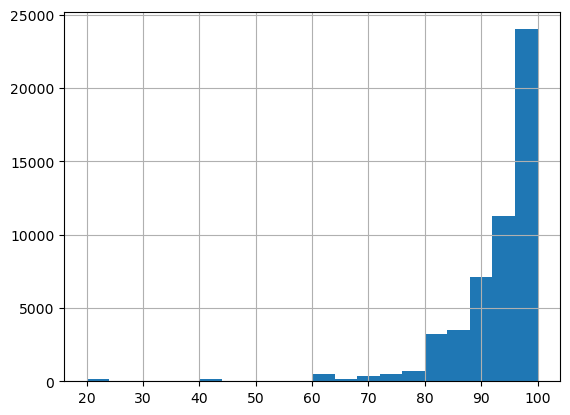

In [98]:
df['guest_rating'].hist(bins=20)

#### 7. Examine distribution of cleanliness scores

<Axes: >

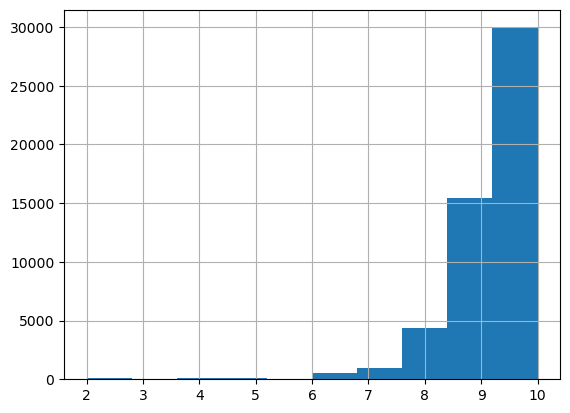

In [99]:
df['cleanliness_score'].hist(bins=10)

#### 8. How does person capacity vary? Most common capacity?

In [102]:
print(df['capacity'].value_counts().to_string())

2    24272
4    13990
3     6155
6     4267
5     2933


#### 9. Distribution of price (weekday vs weekend)

<Axes: title={'center': 'price'}, xlabel='day_type'>

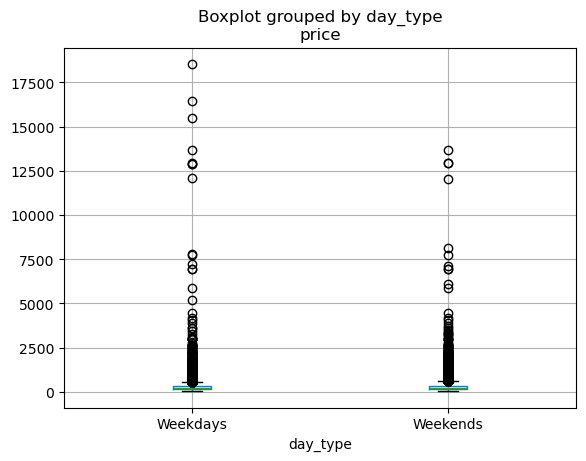

In [106]:
df.boxplot(column = 'price', by = 'day_type')

#### 11. Compare average price between cities (weekdays)

In [108]:
df_week = df[df['day_type'] == 'Weekdays']
print(df_week.groupby('city')['price'].mean().round(2).to_string())

city
Amsterdam    545.21
Athens       155.87
Barcelona    288.39
Berlin       240.23
Budapest     168.50
Lisbon       236.43
London       360.25
Paris        398.93
Rome         201.70
Vienna       240.21


#### 12. Does price tend to be higher on weekends?

In [109]:
print(df.groupby('day_type')['price'].mean().round(2).to_string())

day_type
Weekdays    275.77
Weekends    284.05


#### 13. Are superhosts more expensive?

In [111]:
print(df.groupby('is_superhost')['price'].mean().round(2).to_string())

is_superhost
False    288.66
True     254.63


#### 14. Are superhosts closer to center and metro?

In [112]:
print(df.groupby('is_superhost')[['distance_to_center', 'distance_to_metro']].mean().round(2).to_string())

              distance_to_center  distance_to_metro
is_superhost                                       
False                       3.27               0.68
True                        2.97               0.68


#### 15. Are superhosts cleaner?

In [113]:
print(df.groupby('is_superhost')['cleanliness_score'].mean().round(2).to_string())

is_superhost
False    9.24
True     9.83


#### 16. Is renting entire home/apt more expensive? By city?

In [114]:
print(df.groupby(['city', 'room_category'])['price'].mean().round(2).to_string())

city       room_category  
Amsterdam  Entire home/apt    734.70
           Private room       383.52
           Shared room        280.91
Athens     Entire home/apt    155.08
           Private room       112.98
           Shared room         78.61
Barcelona  Entire home/apt    629.86
           Private room       214.71
           Shared room        124.07
Berlin     Entire home/apt    363.21
           Private room       180.49
           Shared room        153.19
Budapest   Entire home/apt    184.65
           Private room       109.05
           Shared room        126.83
Lisbon     Entire home/apt    282.40
           Private room       148.95
           Shared room        103.06
London     Entire home/apt    544.70
           Private room       220.35
           Shared room        179.82
Paris      Entire home/apt    425.09
           Private room       299.49
           Shared room        152.36
Rome       Entire home/apt    240.76
           Private room       148.77
           